# 長程-建立模型-艙等分開

出發日期                   0
出發時間                   0
出發時段                   0
星期                     0
出發機場代號                 0
抵達時間                   0
抵達時段                   0
抵達機場代號                 0
航空公司                   0
航空公司（主航段）              2
航空公司組合                 0
航空聯盟                   0
停靠站數量                  0
停留時間                   0
停留時間_分鐘                0
飛行時間                   0
飛行時間_分鐘                0
是否過夜                   0
是否為平日                  0
機型                     0
機型（主航段）                1
機型分類                   0
航班代碼                   0
航班代碼（主航段）              1
艙等                     0
艙等分類                   0
艙等分類_new               0
假期                     0
艙等（主航段）              865
第一段飛行時間                4
第二段飛行時間                4
飛行時間兩段分類               0
平均價格                   0
最低價格                   0
中位數價格                  0
價格變異                   0
隨機購買平均價格               0
最低價格剩餘天數               0
筆數                     0
平均價格_log               0


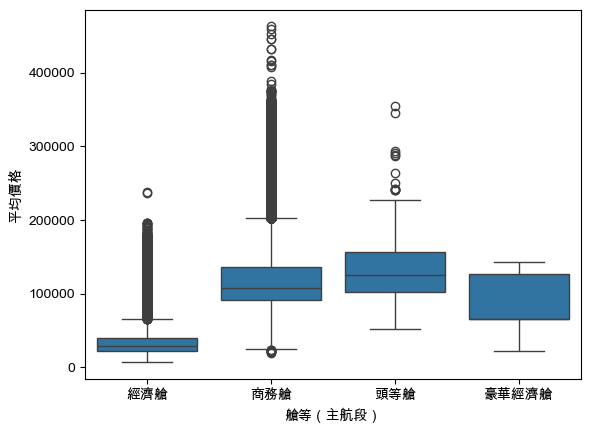

艙等（主航段）
經濟艙      48509
商務艙      40940
頭等艙        374
豪華經濟艙      326
Name: count, dtype: int64
停靠站數量
1    61579
0    29435
Name: count, dtype: int64


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# 檢查是否有缺失值
print(data.isnull().sum())

# 顯示上列ㄉ盒型圖
sns.boxplot(x='艙等（主航段）', y='平均價格', data=data)
plt.show()

# 顯示艙等（主航段）各個數量
print(data['艙等（主航段）'].value_counts())

# 顯示停靠站數量其各個數量
print(data['停靠站數量'].value_counts())

## 特徵重要性圖


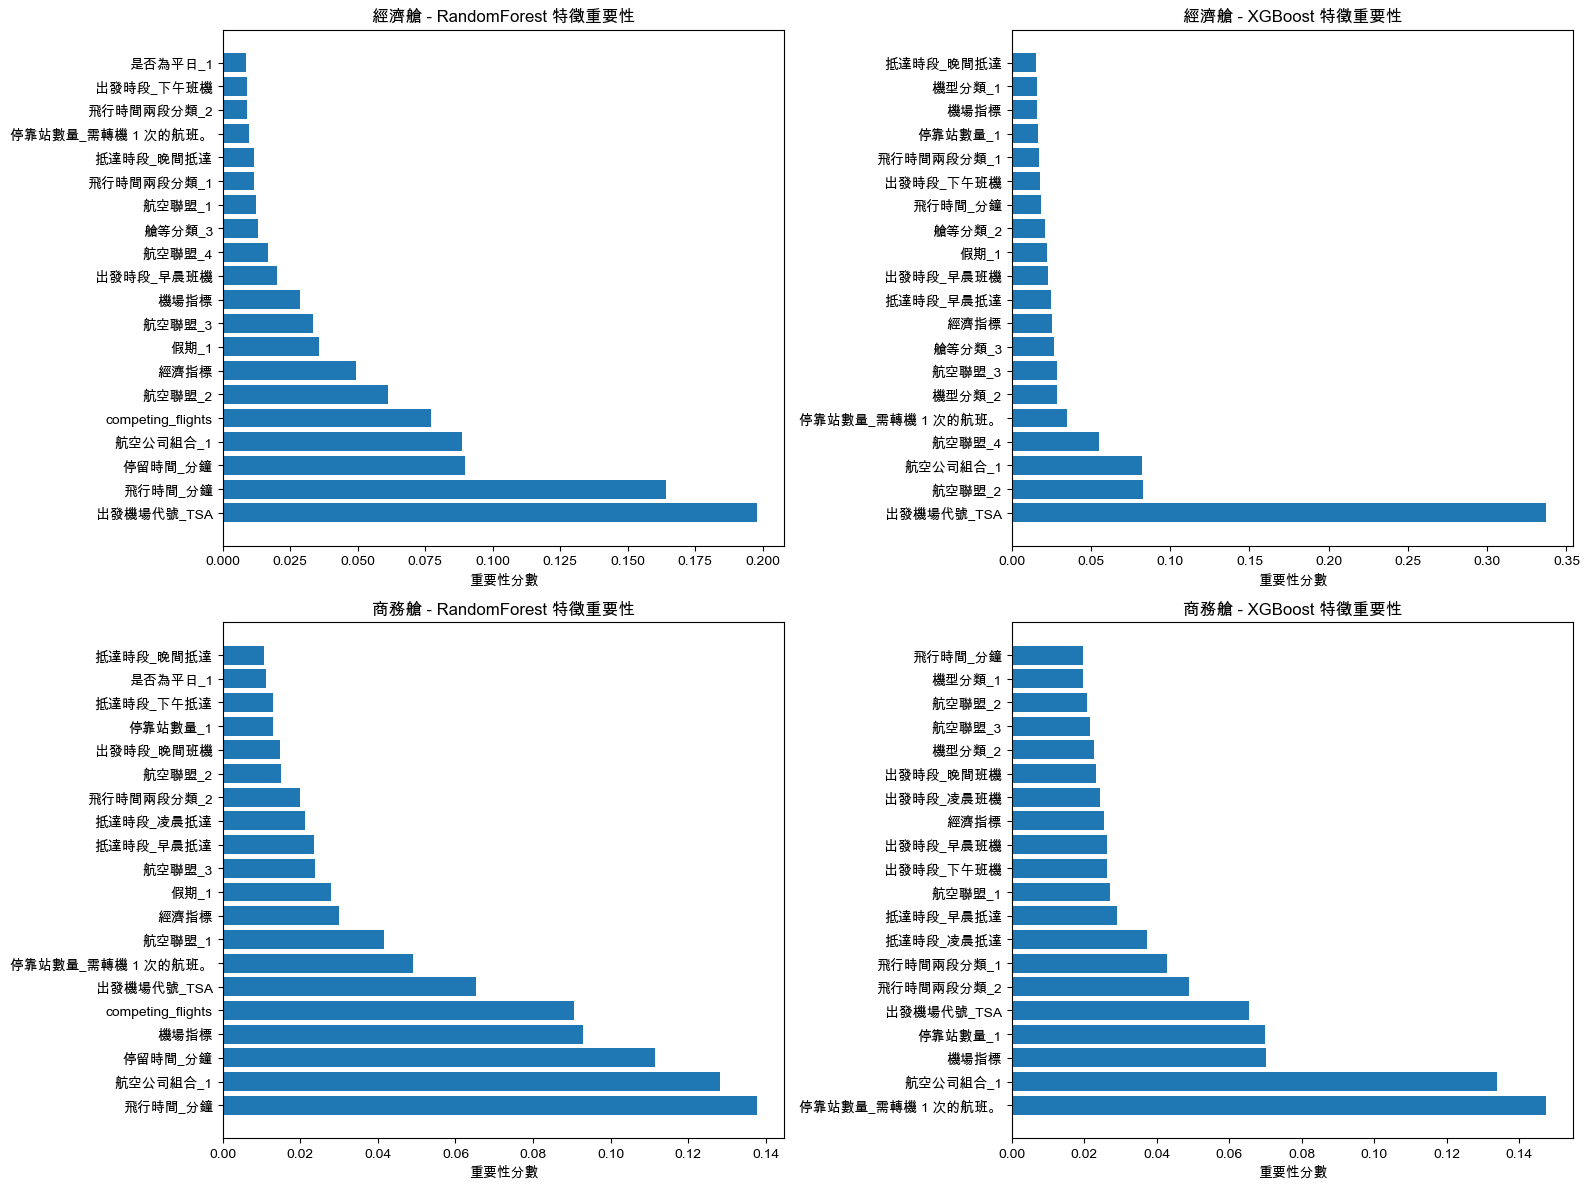

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# 分離經濟艙與非經濟艙的數據
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"]
business_class_data = data[data["艙等（主航段）"] == "商務艙"]

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜', '是否為平日', 
                    '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等分類', '艙等分類_new']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
business_class_data = pd.get_dummies(business_class_data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
business_class_data[num_cols] = scaler.transform(business_class_data[num_cols])

# 確保兩個數據集擁有相同的特徵欄位
common_cols = list(set(economy_class_data.columns) & set(business_class_data.columns))
economy_class_data = economy_class_data[common_cols]
business_class_data = business_class_data[common_cols]

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', '飛行時間兩段分類_', '艙等分類_', '艙等分類_new_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
business_class_data_dummy_cols = [col for col in business_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + ['飛行時間_分鐘', '停留時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
business_class_data_feature_cols = business_class_data_dummy_cols + ['飛行時間_分鐘', '停留時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義自變數與目標變數
X_economy = economy_class_data[economy_class_data_feature_cols]
y_economy = economy_class_data["平均價格_log"]

X_non_economy = business_class_data[business_class_data_feature_cols]
y_non_economy = business_class_data["平均價格_log"]

# 定義函數來訓練模型並獲取特徵重要性
def get_feature_importance(X, y):
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=123, n_jobs=-1)
    rf_model.fit(X, y)
    rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=123, n_jobs=-1, verbosity=0)
    xgb_model.fit(X, y)
    xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    return rf_importance, xgb_importance

# 訓練並獲取特徵重要性
rf_importance_economy, xgb_importance_economy = get_feature_importance(X_economy, y_economy)
rf_importance_non_economy, xgb_importance_non_economy = get_feature_importance(X_non_economy, y_non_economy)

# 繪製特徵重要性圖
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 經濟艙
axes[0,0].barh(rf_importance_economy.index[:20], rf_importance_economy.values[:20])
axes[0,0].set_title("經濟艙 - RandomForest 特徵重要性")
axes[0,0].set_xlabel("重要性分數")

axes[0,1].barh(xgb_importance_economy.index[:20], xgb_importance_economy.values[:20])
axes[0,1].set_title("經濟艙 - XGBoost 特徵重要性")
axes[0,1].set_xlabel("重要性分數")

axes[1,0].barh(rf_importance_non_economy.index[:20], rf_importance_non_economy.values[:20])
axes[1,0].set_title("商務艙 - RandomForest 特徵重要性")
axes[1,0].set_xlabel("重要性分數")

axes[1,1].barh(xgb_importance_non_economy.index[:20], xgb_importance_non_economy.values[:20])
axes[1,1].set_title("商務艙 - XGBoost 特徵重要性")
axes[1,1].set_xlabel("重要性分數")

plt.tight_layout()
plt.show()

## 5次模擬

In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# 分離經濟艙與非經濟艙的數據
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"]
business_class_data = data[data["艙等（主航段）"] == "商務艙"]

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜', '是否為平日', 
                    '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等分類', '艙等分類_new']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
business_class_data = pd.get_dummies(business_class_data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
business_class_data[num_cols] = scaler.transform(business_class_data[num_cols])

# 確保兩個數據集擁有相同的特徵欄位
common_cols = list(set(economy_class_data.columns) & set(business_class_data.columns))
economy_class_data = economy_class_data[common_cols]
business_class_data = business_class_data[common_cols]

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '假期_', '飛行時間兩段分類_', '艙等分類_', '艙等分類_new_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
business_class_data_dummy_cols = [col for col in business_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + ['飛行時間_分鐘', '停留時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
business_class_data_feature_cols = business_class_data_dummy_cols + ['飛行時間_分鐘', '停留時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}

    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # SVR
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    return cabin_type, result

# 設定要運行的隨機種子數量
seeds = [123, 234, 345, 456, 567]

# 平行運算經濟艙與非經濟艙
all_results_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, economy_class_data[economy_class_data_feature_cols], economy_class_data["平均價格_log"], "經濟艙") for seed in seeds)
all_results_business = Parallel(n_jobs=-1)(delayed(run_model)(seed, business_class_data[business_class_data_feature_cols], business_class_data["平均價格_log"], "商務艙") for seed in seeds)

# 解析結果
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }

    for _, res in all_results:
        for model in results.keys():
            results[model]['MSE'].append(res[model]['MSE'])
            results[model]['R2'].append(res[model]['R2'])
            results[model]['RMSE'].append(res[model]['RMSE'])
            results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

    avg_results = {}
    for model, metrics in results.items():
        avg_results[model] = {
            'Average MSE': np.mean(metrics['MSE']),
            'Average R2': np.mean(metrics['R2']),
            'Average RMSE': np.mean(metrics['RMSE']),
            'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
        }
    
    print(f"\n{cabin_type} - Average Performance over {len(seeds)} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        print(f"  MSE = {scores['Average MSE']:.4f}")
        print(f"  R^2 = {scores['Average R2']:.4f}")
        print(f"  RMSE = {scores['Average RMSE']:.4f}")
        print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

# 顯示結果
process_results(all_results_economy, "經濟艙")
process_results(all_results_business, "商務艙")

## 分成四種跑1次

**群組 1：經濟艙**

篩選條件：艙等（主航段） == "經濟艙"
使用欄位：以原始「艙等分類」做 One-hot encoding

**群組 2：非經濟艙**

篩選條件：艙等（主航段） != "經濟艙"
使用欄位：以原始「艙等分類」做 One-hot encoding

**群組 3：商務艙**

篩選條件：艙等（主航段） == "商務艙"
使用欄位：以「艙等分類_new」做 One-hot encoding

**群組 4：非經濟艙扣除豪華經濟艙**

篩選條件：艙等（主航段） != "經濟艙" 且 艙等（主航段） != "豪華經濟艙"
使用欄位：以原始「艙等分類」做 One-hot encoding

In [85]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import lightgbm as lgb
from catboost import CatBoostRegressor

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# === 群組劃分 ===
# 群組 1：經濟艙：艙等（主航段） == "經濟艙"
group1 = data[data["艙等（主航段）"] == "經濟艙"].copy()
# 群組 2：非經濟艙：艙等（主航段） != "經濟艙"
group2 = data[data["艙等（主航段）"] != "經濟艙"].copy()
# 群組 3：商務艙：艙等（主航段） == "商務艙"
group3 = data[data["艙等（主航段）"] == "商務艙"].copy()
# 群組 4：非經濟艙扣除豪華經濟艙：艙等（主航段） != "經濟艙" 且 艙等（主航段） != "豪華經濟艙"
group4 = data[(data["艙等（主航段）"] != "經濟艙") & (data["艙等（主航段）"] != "豪華經濟艙")].copy()

# === 前處理函數 ===
def preprocess(df, dummy_source):
    """
    進行 One-hot encoding 與數值標準化
    dummy_source: 用來做 dummy 的欄位，群組 1、2、4用 "艙等分類"，群組 3用 "艙等分類_new"
    """
    categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                        '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜', '是否為平日', 
                        '機型分類', '假期', 'Region', '飛行時間兩段分類', dummy_source]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    # 若有缺失值移除並顯示移除多少筆
    missing_rows = df.isnull().any(axis=1)
    if missing_rows.sum() > 0:
        print(f"移除 {missing_rows.sum()} 筆包含缺失值的資料")
        df = df[~missing_rows]
    return df

# 前處理各群組
# 群組 1、2、4 使用 "艙等分類"
group1 = preprocess(group1, "艙等分類")
group2 = preprocess(group2, "艙等分類")
group4 = preprocess(group4, "艙等分類")
# 群組 3 使用 "艙等分類_new"
group3 = preprocess(group3, "艙等分類_new")

# === 選取建模特徵 ===
def get_feature_cols(df, target_keywords, additional_cols):
    dummy_cols = [col for col in df.columns if any(keyword in col for keyword in target_keywords)]
    return dummy_cols + additional_cols

num_features = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
target_keywords_default = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '假期_', '飛行時間兩段分類_', '艙等分類_']

business_target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '假期_', '飛行時間兩段分類_', '艙等分類_new_']

economy_feature_cols = get_feature_cols(group1, target_keywords_default, num_features)
non_economy_feature_cols = get_feature_cols(group2, target_keywords_default, num_features)
non_econ_excl_feature_cols = get_feature_cols(group4, target_keywords_default, num_features)
business_feature_cols = get_feature_cols(group3, business_target_keywords, num_features)

# === 模型訓練與評估函數（僅用測試集） ===
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # SVR
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    return cabin_type, result

# 設定隨機種子
seeds = [123]

# 使用 Parallel 分別計算各群組的結果
results_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, group1[economy_feature_cols], group1["平均價格_log"], "經濟艙") for seed in seeds)
results_non_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, group2[non_economy_feature_cols], group2["平均價格_log"], "非經濟艙") for seed in seeds)
results_business = Parallel(n_jobs=-1)(delayed(run_model)(seed, group3[business_feature_cols], group3["平均價格_log"], "商務艙") for seed in seeds)
results_non_econ_excl = Parallel(n_jobs=-1)(delayed(run_model)(seed, group4[non_econ_excl_feature_cols], group4["平均價格_log"], "非經濟艙扣除豪華經濟艙") for seed in seeds)

# 定義函數解析結果，計算平均評估指標
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }
    for _, res in all_results:
        for model in results.keys():
            results[model]['MSE'].append(res[model]['MSE'])
            results[model]['R2'].append(res[model]['R2'])
            results[model]['RMSE'].append(res[model]['RMSE'])
            results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])
    avg_results = {}
    for model, metrics in results.items():
        avg_results[model] = {
            'Average MSE': np.mean(metrics['MSE']),
            'Average R2': np.mean(metrics['R2']),
            'Average RMSE': np.mean(metrics['RMSE']),
            'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
        }
    print(f"\n{cabin_type} - Average Performance over {len(seeds)} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        print(f"  MSE = {scores['Average MSE']:.4f}")
        print(f"  R² = {scores['Average R2']:.4f}")
        print(f"  RMSE = {scores['Average RMSE']:.4f}")
        print(f"  Adjusted R² = {scores['Average Adjusted_R2']:.4f}")

# 顯示結果
process_results(results_economy, "經濟艙")
process_results(results_non_economy, "非經濟艙")
process_results(results_business, "商務艙")
process_results(results_non_econ_excl, "非經濟艙扣除豪華經濟艙")

移除 2 筆包含缺失值的資料
移除 868 筆包含缺失值的資料
移除 868 筆包含缺失值的資料
移除 3 筆包含缺失值的資料

經濟艙 - Average Performance over 1 runs:
RandomForest:
  MSE = 0.0351
  R² = 0.8854
  RMSE = 0.1875
  Adjusted R² = 0.8851
SVR:
  MSE = 0.0732
  R² = 0.7613
  RMSE = 0.2706
  Adjusted R² = 0.7607
XGBoost:
  MSE = 0.0371
  R² = 0.8791
  RMSE = 0.1925
  Adjusted R² = 0.8788

非經濟艙 - Average Performance over 1 runs:
RandomForest:
  MSE = 0.0222
  R² = 0.8366
  RMSE = 0.1489
  Adjusted R² = 0.8362
SVR:
  MSE = 0.0376
  R² = 0.7225
  RMSE = 0.1940
  Adjusted R² = 0.7218
XGBoost:
  MSE = 0.0216
  R² = 0.8410
  RMSE = 0.1469
  Adjusted R² = 0.8406

商務艙 - Average Performance over 1 runs:
RandomForest:
  MSE = 0.0220
  R² = 0.8394
  RMSE = 0.1482
  Adjusted R² = 0.8390
SVR:
  MSE = 0.0303
  R² = 0.7785
  RMSE = 0.1741
  Adjusted R² = 0.7780
XGBoost:
  MSE = 0.0208
  R² = 0.8478
  RMSE = 0.1443
  Adjusted R² = 0.8474

非經濟艙扣除豪華經濟艙 - Average Performance over 1 runs:
RandomForest:
  MSE = 0.0221
  R² = 0.8369
  RMSE = 0.1486
  Adjusted R

## 分成四種並加上 lightgbm & catboost 跑1次

In [91]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import lightgbm as lgb
from catboost import CatBoostRegressor

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# === 群組劃分 ===
# 群組 1：經濟艙：艙等（主航段） == "經濟艙"
group1 = data[data["艙等（主航段）"] == "經濟艙"].copy()
# 群組 2：非經濟艙：艙等（主航段） != "經濟艙"
group2 = data[data["艙等（主航段）"] != "經濟艙"].copy()
# 群組 3：商務艙：艙等（主航段） == "商務艙"
group3 = data[data["艙等（主航段）"] == "商務艙"].copy()
# 群組 4：非經濟艙扣除豪華經濟艙：艙等（主航段） != "經濟艙" 且 艙等（主航段） != "豪華經濟艙"
group4 = data[(data["艙等（主航段）"] != "經濟艙") & (data["艙等（主航段）"] != "豪華經濟艙")].copy()

# === 前處理函數：One-hot encoding 版本（供非 CatBoost 模型使用） ===
def preprocess_enc(df, dummy_source):
    """
    進行 One-hot encoding 與數值標準化，並移除特徵名稱中的空白字元
    dummy_source: 群組 1、2、4 用 "艙等分類"，群組 3 用 "艙等分類_new"
    """
    categorical_cols = ['出發時段', '出發機場代號', '抵達時段',
                          '航空公司組合', '航空聯盟', '停靠站數量', 
                          '機型分類', '假期', '飛行時間兩段分類', dummy_source]
    # 先進行 one-hot encoding
    df_enc = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    # 移除特徵名稱中的空白字元
    df_enc.columns = df_enc.columns.str.replace(r'\s+', '_', regex=True)
    
    num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
    scaler = StandardScaler()
    df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])
    
    # 移除缺失值
    missing_rows = df_enc.isnull().any(axis=1)
    if missing_rows.sum() > 0:
        print(f"移除 {missing_rows.sum()} 筆包含缺失值的資料 (enc)")
        df_enc = df_enc[~missing_rows]
    return df_enc

# === 前處理函數：CatBoost 版本（保留原始類別變數） ===
def preprocess_cat(df, dummy_source):
    """
    僅對數值欄位進行標準化，保留原始類別變數，供 CatBoost 使用
    """
    # 直接保留原始類別變數，不做 one-hot encoding
    num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    # 移除缺失值（針對所有欄位）
    missing_rows = df.isnull().any(axis=1)
    if missing_rows.sum() > 0:
        print(f"移除 {missing_rows.sum()} 筆包含缺失值的資料 (cat)")
        df = df[~missing_rows]
        
    # 同樣移除欄位名稱中的空白字元（避免後續處理出現警告）
    df.columns = df.columns.str.replace(r'\s+', '_', regex=True)
    return df

# 前處理各群組：
# 針對非 CatBoost 模型
group1_enc = preprocess_enc(group1, "艙等分類")
group2_enc = preprocess_enc(group2, "艙等分類")
group4_enc = preprocess_enc(group4, "艙等分類")
group3_enc = preprocess_enc(group3, "艙等分類_new")
# 針對 CatBoost 模型（保留原始類別變數）
group1_cat = preprocess_cat(group1, "艙等分類")
group2_cat = preprocess_cat(group2, "艙等分類")
group4_cat = preprocess_cat(group4, "艙等分類")
group3_cat = preprocess_cat(group3, "艙等分類_new")

# === 選取建模特徵 ===
# 對 One-hot encoding 版本
def get_feature_cols(df, target_keywords, additional_cols):
    dummy_cols = [col for col in df.columns if any(keyword in col for keyword in target_keywords)]
    return dummy_cols + additional_cols

num_features = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
target_keywords_default = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                           '機型分類_', '假期_', '飛行時間兩段分類_', '艙等分類_']
business_target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                            '機型分類_', '假期_', '飛行時間兩段分類_', '艙等分類_new_']

economy_feature_cols = get_feature_cols(group1_enc, target_keywords_default, num_features)
non_economy_feature_cols = get_feature_cols(group2_enc, target_keywords_default, num_features)
non_econ_excl_feature_cols = get_feature_cols(group4_enc, target_keywords_default, num_features)
business_feature_cols = get_feature_cols(group3_enc, business_target_keywords, num_features)

# 對 CatBoost 模型，直接取原始類別與數值欄位
# 定義數值欄位與類別欄位（注意 dummy_source 為變數名稱）
cat_numeric_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
def get_catboost_features(df, dummy_source):
    cat_cols = ['出發時段', '出發機場代號', '抵達時段', '航空公司組合', 
                '航空聯盟', '停靠站數量', '機型分類', '假期', '飛行時間兩段分類', dummy_source]
    return cat_numeric_cols + cat_cols

economy_cat_features = get_catboost_features(group1_cat, "艙等分類")
non_economy_cat_features = get_catboost_features(group2_cat, "艙等分類")
non_econ_excl_cat_features = get_catboost_features(group4_cat, "艙等分類")
business_cat_features = get_catboost_features(group3_cat, "艙等分類_new")

# === 模型訓練與評估函數（使用相同分割 indices 分別訓練非 CatBoost 與 CatBoost 模型） ===
def run_model(seed, X_enc, X_cat, y, cat_feature_list, dummy_source, cabin_type):
    # 取得分割索引
    indices = np.arange(len(y))
    train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=seed)
    
    X_enc_train = X_enc.iloc[train_idx]
    X_enc_test  = X_enc.iloc[test_idx]
    X_cat_train = X_cat.loc[X_enc.index.intersection(X_cat.index)].iloc[train_idx]
    X_cat_test  = X_cat.loc[X_enc.index.intersection(X_cat.index)].iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]
    
    n_test = len(y_test)
    p = X_enc.shape[1]
    
    result = {}
    
    # 隨機森林（用 one-hot encoding 版）
    rf_model = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_model.fit(X_enc_train, y_train)
    y_pred_rf = rf_model.predict(X_enc_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # SVR（用 one-hot encoding 版）
    svr_model = SVR()
    svr_model.fit(X_enc_train, y_train)
    y_pred_svr = svr_model.predict(X_enc_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    # XGBoost（用 one-hot encoding 版）
    xgb_model = XGBRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    xgb_model.fit(X_enc_train, y_train)
    y_pred_xgb = xgb_model.predict(X_enc_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    # LightGBM（用 one-hot encoding 版）
    lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=seed, n_jobs=-1, verbose=-1)
    lgb_model.fit(X_enc_train, y_train)
    y_pred_lgb = lgb_model.predict(X_enc_test)
    mse_lgb = mean_squared_error(y_test, y_pred_lgb)
    r2_lgb = r2_score(y_test, y_pred_lgb)
    rmse_lgb = np.sqrt(mse_lgb)
    adjusted_r_lgb = 1 - (1 - r2_lgb) * (n_test - 1) / (n_test - p - 1)
    result['LightGBM'] = {'MSE': mse_lgb, 'R2': r2_lgb, 'RMSE': rmse_lgb, 'Adjusted_R2': adjusted_r_lgb}
    
    # CatBoost（使用原始類別變數）
    # 先從 X_cat_train 與 X_cat_test 中取出僅包含 cat_feature_list 的子資料框
    X_cat_train_sub = X_cat_train[cat_feature_list]
    X_cat_test_sub  = X_cat_test[cat_feature_list]
    
    # 定義原始類別特徵欄位（不含數值欄位）
    cat_cols = ['出發時段', '出發機場代號', '抵達時段', '航空公司組合',
                '航空聯盟', '停靠站數量', '機型分類', '假期', '飛行時間兩段分類', dummy_source]
    # 依據子資料框重新計算類別特徵的索引
    cat_features = [i for i, col in enumerate(X_cat_train_sub.columns) if col in cat_cols]
    
    cat_model = CatBoostRegressor(n_estimators=100, random_state=seed, verbose=0)
    cat_model.fit(X_cat_train_sub, y_train, cat_features=cat_features)
    y_pred_cat = cat_model.predict(X_cat_test_sub)
    mse_cat = mean_squared_error(y_test, y_pred_cat)
    r2_cat = r2_score(y_test, y_pred_cat)
    rmse_cat = np.sqrt(mse_cat)
    adjusted_r_cat = 1 - (1 - r2_cat) * (n_test - 1) / (n_test - p - 1)
    result['CatBoost'] = {'MSE': mse_cat, 'R2': r2_cat, 'RMSE': rmse_cat, 'Adjusted_R2': adjusted_r_cat}
    
    return cabin_type, result

# 設定隨機種子
seeds = [123]

# 使用 Parallel 分別計算各群組的結果
results_economy = Parallel(n_jobs=-1)(
    delayed(run_model)(
        seed, 
        group1_enc[economy_feature_cols], 
        group1_cat, 
        group1_enc["平均價格_log"], 
        get_catboost_features(group1_cat, "艙等分類"),
        "艙等分類",
        "經濟艙"
    ) for seed in seeds
)
results_non_economy = Parallel(n_jobs=-1)(
    delayed(run_model)(
        seed, 
        group2_enc[non_economy_feature_cols], 
        group2_cat, 
        group2_enc["平均價格_log"], 
        get_catboost_features(group2_cat, "艙等分類"),
        "艙等分類",
        "非經濟艙"
    ) for seed in seeds
)
results_business = Parallel(n_jobs=-1)(
    delayed(run_model)(
        seed, 
        group3_enc[business_feature_cols], 
        group3_cat, 
        group3_enc["平均價格_log"], 
        get_catboost_features(group3_cat, "艙等分類_new"),
        "艙等分類_new",
        "商務艙"
    ) for seed in seeds
)
results_non_econ_excl = Parallel(n_jobs=-1)(
    delayed(run_model)(
        seed, 
        group4_enc[non_econ_excl_feature_cols], 
        group4_cat, 
        group4_enc["平均價格_log"], 
        get_catboost_features(group4_cat, "艙等分類"),
        "艙等分類",
        "非經濟艙扣除豪華經濟艙"
    ) for seed in seeds
)

# 定義函數解析結果，計算平均評估指標
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'LightGBM': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'CatBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }
    for _, res in all_results:
        for model in results.keys():
            results[model]['MSE'].append(res[model]['MSE'])
            results[model]['R2'].append(res[model]['R2'])
            results[model]['RMSE'].append(res[model]['RMSE'])
            results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])
    avg_results = {}
    for model, metrics in results.items():
        avg_results[model] = {
            'Average MSE': np.mean(metrics['MSE']),
            'Average R2': np.mean(metrics['R2']),
            'Average RMSE': np.mean(metrics['RMSE']),
            'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
        }
    print(f"\n{cabin_type} - Average Performance over {len(seeds)} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        print(f"  MSE = {scores['Average MSE']:.4f}")
        print(f"  R² = {scores['Average R2']:.4f}")
        print(f"  RMSE = {scores['Average RMSE']:.4f}")
        print(f"  Adjusted R² = {scores['Average Adjusted_R2']:.4f}")

# 顯示結果
process_results(results_economy, "經濟艙")
process_results(results_non_economy, "非經濟艙")
process_results(results_business, "商務艙")
process_results(results_non_econ_excl, "非經濟艙扣除豪華經濟艙")

移除 2 筆包含缺失值的資料 (enc)
移除 868 筆包含缺失值的資料 (enc)
移除 868 筆包含缺失值的資料 (enc)
移除 3 筆包含缺失值的資料 (enc)
移除 2 筆包含缺失值的資料 (cat)
移除 868 筆包含缺失值的資料 (cat)
移除 868 筆包含缺失值的資料 (cat)
移除 3 筆包含缺失值的資料 (cat)

經濟艙 - Average Performance over 1 runs:
RandomForest:
  MSE = 0.0351
  R² = 0.8854
  RMSE = 0.1875
  Adjusted R² = 0.8851
SVR:
  MSE = 0.0732
  R² = 0.7613
  RMSE = 0.2706
  Adjusted R² = 0.7607
XGBoost:
  MSE = 0.0371
  R² = 0.8791
  RMSE = 0.1925
  Adjusted R² = 0.8788
LightGBM:
  MSE = 0.0553
  R² = 0.8195
  RMSE = 0.2352
  Adjusted R² = 0.8192
CatBoost:
  MSE = 0.0517
  R² = 0.8313
  RMSE = 0.2275
  Adjusted R² = 0.8309

非經濟艙 - Average Performance over 1 runs:
RandomForest:
  MSE = 0.0222
  R² = 0.8366
  RMSE = 0.1489
  Adjusted R² = 0.8362
SVR:
  MSE = 0.0376
  R² = 0.7225
  RMSE = 0.1940
  Adjusted R² = 0.7218
XGBoost:
  MSE = 0.0216
  R² = 0.8410
  RMSE = 0.1469
  Adjusted R² = 0.8406
LightGBM:
  MSE = 0.0288
  R² = 0.7873
  RMSE = 0.1698
  Adjusted R² = 0.7868
CatBoost:
  MSE = 0.0308
  R² = 0.7728
  RMSE

**視覺化**

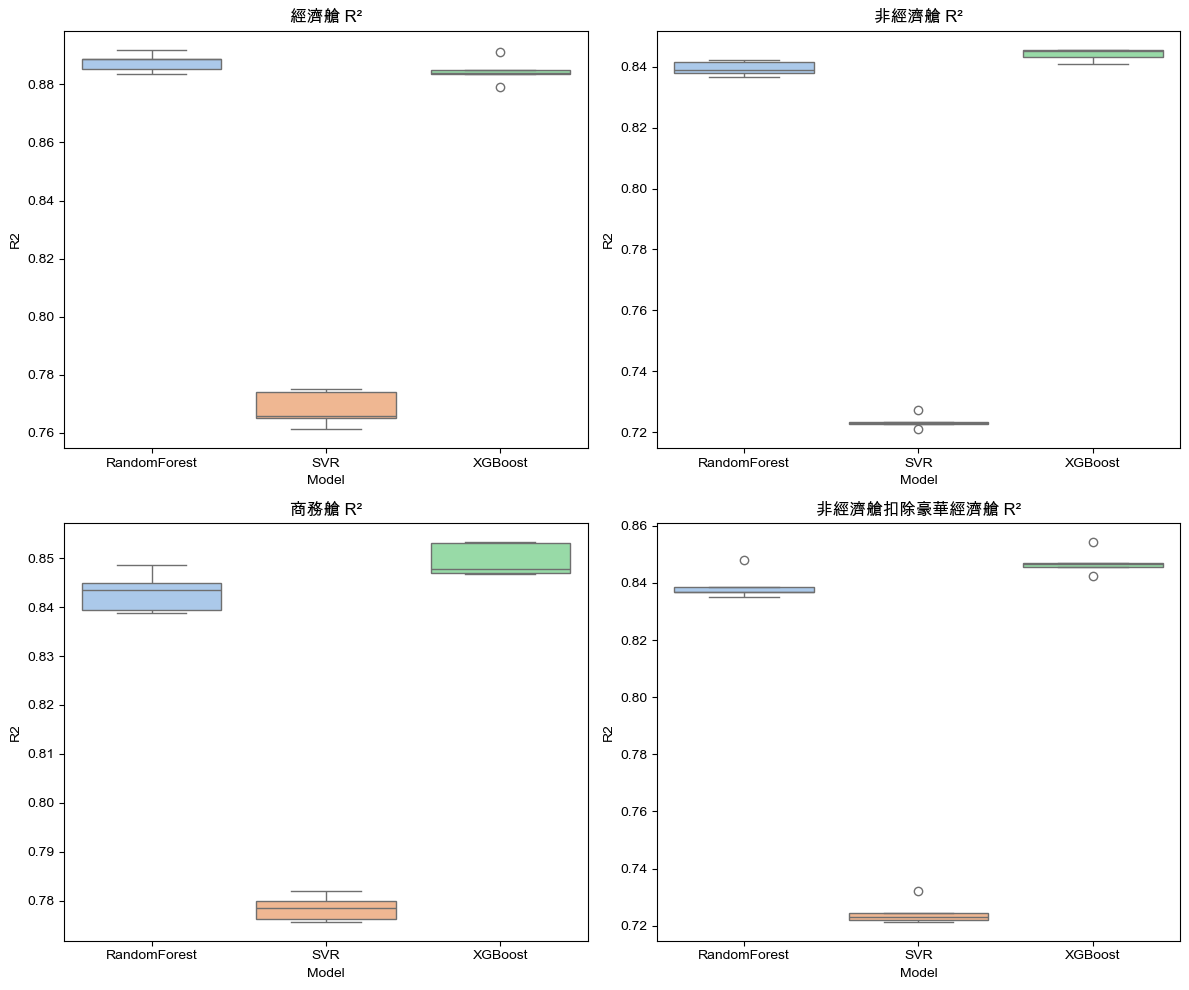

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假設已經從 process_results 或其他方法中獲得各群組的 R² 值 DataFrame，
# 這裡用 extract_R2() 函數示範如何從 results_xxxx 中提取 R² 值，
# 並建立長格式 DataFrame 以便作圖。

def extract_R2(results):
    data = {'RandomForest': [], 'SVR': [], 'XGBoost': []}
    for _, res in results:
        data['RandomForest'].append(res['RandomForest']['R2'])
        data['SVR'].append(res['SVR']['R2'])
        data['XGBoost'].append(res['XGBoost']['R2'])
    return pd.DataFrame(data)

df_economy = extract_R2(results_economy)
df_non_economy = extract_R2(results_non_economy)
df_business = extract_R2(results_business)
df_non_econ_excl = extract_R2(results_non_econ_excl)

# 將 DataFrame 轉為長格式
df_economy_melt = df_economy.melt(var_name='Model', value_name='R2')
df_non_economy_melt = df_non_economy.melt(var_name='Model', value_name='R2')
df_business_melt = df_business.melt(var_name='Model', value_name='R2')
df_non_econ_excl_melt = df_non_econ_excl.melt(var_name='Model', value_name='R2')

# 建立 2x2 子圖
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(x='Model', y='R2', data=df_economy_melt, ax=axes[0, 0],
            hue='Model', legend=False, palette='pastel')
axes[0, 0].set_title("經濟艙 R²")

sns.boxplot(x='Model', y='R2', data=df_non_economy_melt, ax=axes[0, 1],
            hue='Model', legend=False, palette='pastel')
axes[0, 1].set_title("非經濟艙 R²")

sns.boxplot(x='Model', y='R2', data=df_business_melt, ax=axes[1, 0],
            hue='Model', legend=False, palette='pastel')
axes[1, 0].set_title("商務艙 R²")

sns.boxplot(x='Model', y='R2', data=df_non_econ_excl_melt, ax=axes[1, 1],
            hue='Model', legend=False, palette='pastel')
axes[1, 1].set_title("非經濟艙扣除豪華經濟艙 R²")

plt.tight_layout()
plt.show()

**30次平均**

In [7]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# 分離經濟艙與非經濟艙的數據
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"]
non_economy_class_data = data[data["艙等（主航段）"] != "經濟艙"]

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜', '是否為平日', 
                    '機型分類', '假期', 'Region', '飛行時間兩段分類', '艙等分類']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
non_economy_class_data = pd.get_dummies(non_economy_class_data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
non_economy_class_data[num_cols] = scaler.transform(non_economy_class_data[num_cols])

# 確保兩個數據集擁有相同的特徵欄位
common_cols = list(set(economy_class_data.columns) & set(non_economy_class_data.columns))
economy_class_data = economy_class_data[common_cols]
non_economy_class_data = non_economy_class_data[common_cols]

# 選取建模特徵：先挑選 dummy 欄位，再加上數值型特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', '停靠站數量_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '飛行時間兩段分類_', '艙等分類_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
non_economy_class_data_dummy_cols = [col for col in non_economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
non_economy_class_data_feature_cols = non_economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}

    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=1)  # 避免資源過載
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # SVR
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=1)  # 避免資源過載
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    return cabin_type, result

# 設定運行次數（30 次）與隨機種子列表
n_runs = 30
seeds = list(range(n_runs))

# 平行運算經濟艙與非經濟艙
all_results_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, economy_class_data[economy_class_data_feature_cols], economy_class_data["平均價格_log"], "經濟艙") for seed in seeds)
all_results_non_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, non_economy_class_data[non_economy_class_data_feature_cols], non_economy_class_data["平均價格_log"], "非經濟艙") for seed in seeds)

# 統計結果
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }

    for _, res in all_results:
        for model in results.keys():
            results[model]['MSE'].append(res[model]['MSE'])
            results[model]['R2'].append(res[model]['R2'])
            results[model]['RMSE'].append(res[model]['RMSE'])
            results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

    avg_results = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in results.items()}
    
    print(f"\n{cabin_type} - Average Performance over {n_runs} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        for metric, value in scores.items():
            print(f"  {metric} = {value:.4f}")

# 顯示結果
process_results(all_results_economy, "經濟艙")
process_results(all_results_non_economy, "非經濟艙")


經濟艙 - Average Performance over 30 runs:
RandomForest:
  MSE = 0.0352
  R2 = 0.8858
  RMSE = 0.1876
  Adjusted_R2 = 0.8855
SVR:
  MSE = 0.0714
  R2 = 0.7685
  RMSE = 0.2672
  Adjusted_R2 = 0.7680
XGBoost:
  MSE = 0.0833
  R2 = 0.7299
  RMSE = 0.2886
  Adjusted_R2 = 0.7293

非經濟艙 - Average Performance over 30 runs:
RandomForest:
  MSE = 0.0544
  R2 = 0.6621
  RMSE = 0.2331
  Adjusted_R2 = 0.6611
SVR:
  MSE = 0.0603
  R2 = 0.6252
  RMSE = 0.2455
  Adjusted_R2 = 0.6242
XGBoost:
  MSE = 0.0624
  R2 = 0.6121
  RMSE = 0.2498
  Adjusted_R2 = 0.6111


**視覺化**

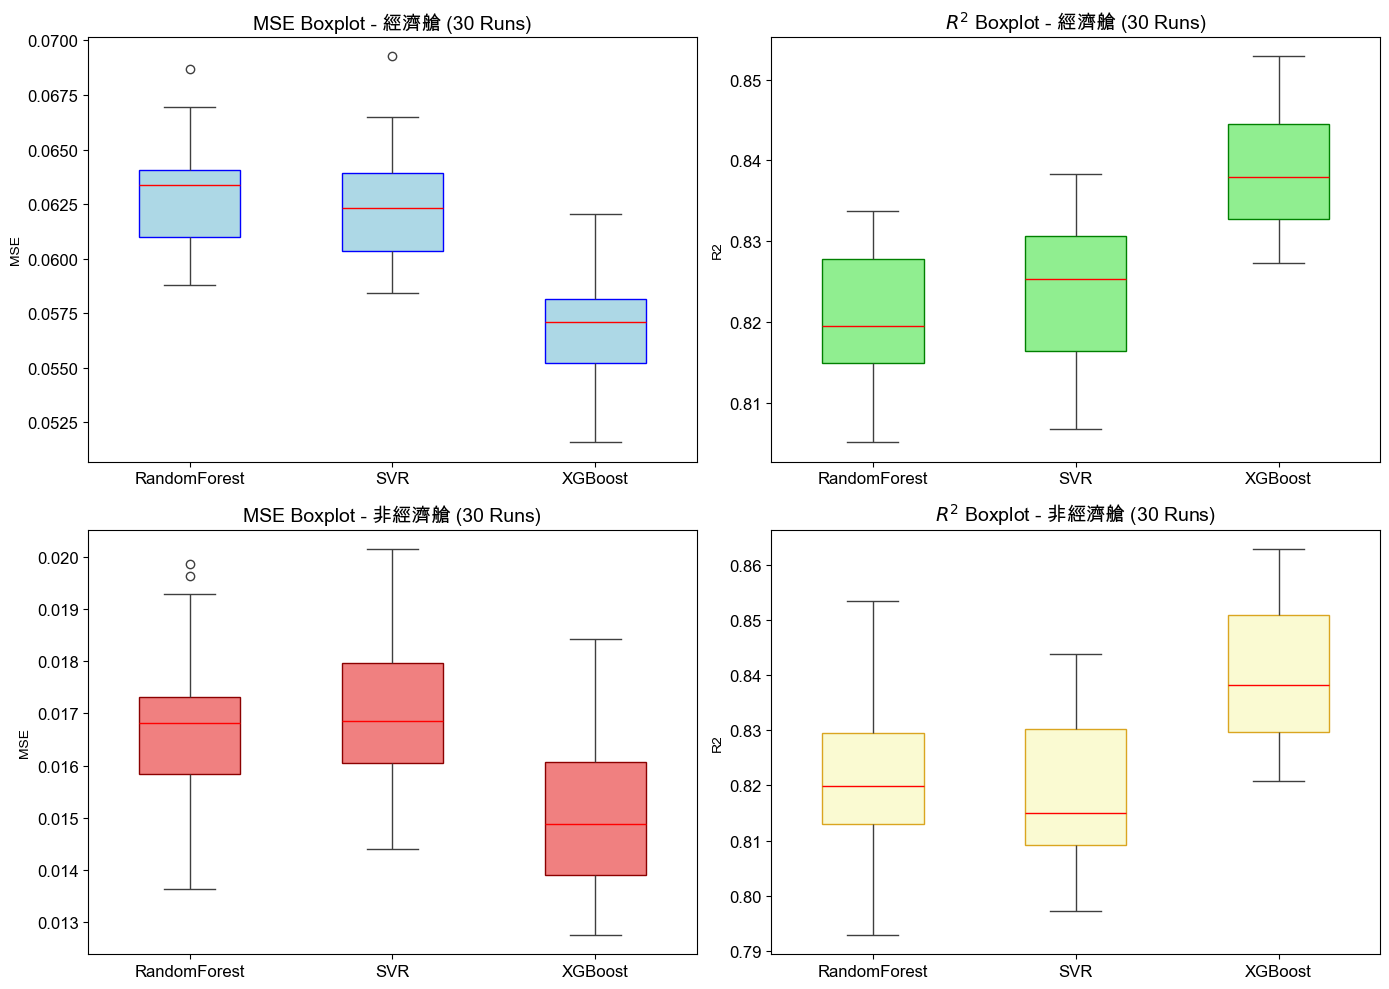

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import seaborn as sns

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 只取出 results（不包含 cabin_type）
all_results_economy_cleaned = [res[1] for res in all_results_economy]  
all_results_non_economy_cleaned = [res[1] for res in all_results_non_economy]

# 轉換為 DataFrame
mse_df_economy = pd.DataFrame({model: [res[model]['MSE'] for res in all_results_economy_cleaned] for model in ['RandomForest', 'SVR', 'XGBoost']})
r2_df_economy = pd.DataFrame({model: [res[model]['R2'] for res in all_results_economy_cleaned] for model in ['RandomForest', 'SVR', 'XGBoost']})

mse_df_non_economy = pd.DataFrame({model: [res[model]['MSE'] for res in all_results_non_economy_cleaned] for model in ['RandomForest', 'SVR', 'XGBoost']})
r2_df_non_economy = pd.DataFrame({model: [res[model]['R2'] for res in all_results_non_economy_cleaned] for model in ['RandomForest', 'SVR', 'XGBoost']})

# 使用 melt 轉換為長格式
mse_long_economy = mse_df_economy.melt(var_name='Model', value_name='MSE')
r2_long_economy = r2_df_economy.melt(var_name='Model', value_name='R2')

mse_long_non_economy = mse_df_non_economy.melt(var_name='Model', value_name='MSE')
r2_long_non_economy = r2_df_non_economy.melt(var_name='Model', value_name='R2')

# 建立 2x2 子圖
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 經濟艙 MSE 盒鬚圖
sns.boxplot(x='Model', y='MSE', data=mse_long_economy, ax=axes[0, 0],
            width=0.5, showfliers=True,
            boxprops={'facecolor': 'lightblue', 'edgecolor': 'blue'},
            medianprops={'color': 'red'})
axes[0, 0].set_title('MSE Boxplot - 經濟艙 (30 Runs)', fontsize=14)
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(labelsize=12)

# 經濟艙 R^2 盒鬚圖
sns.boxplot(x='Model', y='R2', data=r2_long_economy, ax=axes[0, 1],
            width=0.5, showfliers=True,
            boxprops={'facecolor': 'lightgreen', 'edgecolor': 'green'},
            medianprops={'color': 'red'})
axes[0, 1].set_title('$R^2$ Boxplot - 經濟艙 (30 Runs)', fontsize=14)
axes[0, 1].set_xlabel('')
axes[0, 1].tick_params(labelsize=12)

# 非經濟艙 MSE 盒鬚圖
sns.boxplot(x='Model', y='MSE', data=mse_long_non_economy, ax=axes[1, 0],
            width=0.5, showfliers=True,
            boxprops={'facecolor': 'lightcoral', 'edgecolor': 'darkred'},
            medianprops={'color': 'red'})
axes[1, 0].set_title('MSE Boxplot - 非經濟艙 (30 Runs)', fontsize=14)
axes[1, 0].set_xlabel('')
axes[1, 0].tick_params(labelsize=12)

# 非經濟艙 R^2 盒鬚圖
sns.boxplot(x='Model', y='R2', data=r2_long_non_economy, ax=axes[1, 1],
            width=0.5, showfliers=True,
            boxprops={'facecolor': 'lightgoldenrodyellow', 'edgecolor': 'goldenrod'},
            medianprops={'color': 'red'})
axes[1, 1].set_title('$R^2$ Boxplot - 非經濟艙 (30 Runs)', fontsize=14)
axes[1, 1].set_xlabel('')
axes[1, 1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()

In [64]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight_final.csv'
data = pd.read_csv(file_path)

# === 群組劃分 ===
# 群組 1：經濟艙：艙等（主航段） == "經濟艙"
group1 = data[data["艙等（主航段）"] == "經濟艙"].copy()
# 群組 2：非經濟艙：艙等（主航段） != "經濟艙"
group2 = data[data["艙等（主航段）"] != "經濟艙"].copy()
# 群組 3：商務艙：艙等（主航段） == "商務艙"
group3 = data[data["艙等（主航段）"] == "商務艙"].copy()
# 群組 4：非經濟艙扣除豪華經濟艙：艙等（主航段） != "經濟艙" 且 艙等（主航段） != "豪華經濟艙"
group4 = data[(data["艙等（主航段）"] != "經濟艙") & (data["艙等（主航段）"] != "豪華經濟艙")].copy()

# === 前處理函數 ===
def preprocess(df, dummy_source):
    """
    進行 One-hot encoding 與數值標準化
    dummy_source: 用來做 dummy 的欄位，群組 1、2、4用 "艙等分類"，群組 3用 "艙等分類_new"
    """
    categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                        '航空公司組合', '航空聯盟', '停靠站數量', '是否過夜', '是否為平日', 
                        '機型分類', '假期', 'Region', '飛行時間兩段分類', dummy_source]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    # 若有缺失值移除並顯示移除多少筆
    missing_rows = df.isnull().any(axis=1)
    if missing_rows.sum() > 0:
        print(f"移除 {missing_rows.sum()} 筆包含缺失值的資料")
        df = df[~missing_rows]
    return df

# 前處理各群組
# 群組 1、2、4 使用 "艙等分類"
group1 = preprocess(group1, "艙等分類")
group2 = preprocess(group2, "艙等分類")
group4 = preprocess(group4, "艙等分類")
# 群組 3 使用 "艙等分類_new"
group3 = preprocess(group3, "艙等分類_new")

# === 選取建模特徵 ===
def get_feature_cols(df, target_keywords, additional_cols):
    dummy_cols = [col for col in df.columns if any(keyword in col for keyword in target_keywords)]
    return dummy_cols + additional_cols

num_features = ['停留時間_分鐘', '飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
target_keywords_default = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '飛行時間兩段分類_', '艙等分類_']

business_target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空公司組合_', '航空聯盟_', 
                   '機型分類_', '是否為平日_', '假期_', 'Region_', '飛行時間兩段分類_', '艙等分類_new_']

economy_feature_cols = get_feature_cols(group1, target_keywords_default, num_features)
non_economy_feature_cols = get_feature_cols(group2, target_keywords_default, num_features)
non_econ_excl_feature_cols = get_feature_cols(group4, target_keywords_default, num_features)
business_feature_cols = get_feature_cols(group3, business_target_keywords, num_features)

# === 模型訓練與評估函數（僅用測試集） ===
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # SVR
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=6,
                             random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    return cabin_type, result

## 設定運行次數（30 次）與隨機種子列表
n_runs = 30
seeds = list(range(n_runs))

# 使用 Parallel 分別計算各群組的結果
results_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, group1[economy_feature_cols], group1["平均價格_log"], "經濟艙") for seed in seeds)
results_non_economy = Parallel(n_jobs=-1)(delayed(run_model)(seed, group2[non_economy_feature_cols], group2["平均價格_log"], "非經濟艙") for seed in seeds)
results_business = Parallel(n_jobs=-1)(delayed(run_model)(seed, group3[business_feature_cols], group3["平均價格_log"], "商務艙") for seed in seeds)
results_non_econ_excl = Parallel(n_jobs=-1)(delayed(run_model)(seed, group4[non_econ_excl_feature_cols], group4["平均價格_log"], "非經濟艙扣除豪華經濟艙") for seed in seeds)

# 定義函數解析結果，計算平均評估指標
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }
    for _, res in all_results:
        for model in results.keys():
            results[model]['MSE'].append(res[model]['MSE'])
            results[model]['R2'].append(res[model]['R2'])
            results[model]['RMSE'].append(res[model]['RMSE'])
            results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])
    avg_results = {}
    for model, metrics in results.items():
        avg_results[model] = {
            'Average MSE': np.mean(metrics['MSE']),
            'Average R2': np.mean(metrics['R2']),
            'Average RMSE': np.mean(metrics['RMSE']),
            'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
        }
    print(f"\n{cabin_type} - Average Performance over {len(seeds)} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        print(f"  MSE = {scores['Average MSE']:.4f}")
        print(f"  R² = {scores['Average R2']:.4f}")
        print(f"  RMSE = {scores['Average RMSE']:.4f}")
        print(f"  Adjusted R² = {scores['Average Adjusted_R2']:.4f}")

# 顯示結果
process_results(results_economy, "經濟艙")
process_results(results_non_economy, "非經濟艙")
process_results(results_business, "商務艙")
process_results(results_non_econ_excl, "非經濟艙扣除豪華經濟艙")

移除 2 筆包含缺失值的資料
移除 868 筆包含缺失值的資料
移除 868 筆包含缺失值的資料
移除 3 筆包含缺失值的資料

經濟艙 - Average Performance over 30 runs:
RandomForest:
  MSE = 0.0314
  R² = 0.8981
  RMSE = 0.1773
  Adjusted R² = 0.8978
SVR:
  MSE = 0.0671
  R² = 0.7826
  RMSE = 0.2589
  Adjusted R² = 0.7820
XGBoost:
  MSE = 0.0733
  R² = 0.7622
  RMSE = 0.2708
  Adjusted R² = 0.7616

非經濟艙 - Average Performance over 30 runs:
RandomForest:
  MSE = 0.0207
  R² = 0.8495
  RMSE = 0.1438
  Adjusted R² = 0.8490
SVR:
  MSE = 0.0355
  R² = 0.7417
  RMSE = 0.1884
  Adjusted R² = 0.7410
XGBoost:
  MSE = 0.0348
  R² = 0.7469
  RMSE = 0.1865
  Adjusted R² = 0.7461

商務艙 - Average Performance over 30 runs:
RandomForest:
  MSE = 0.0202
  R² = 0.8499
  RMSE = 0.1421
  Adjusted R² = 0.8495
SVR:
  MSE = 0.0291
  R² = 0.7837
  RMSE = 0.1706
  Adjusted R² = 0.7830
XGBoost:
  MSE = 0.0330
  R² = 0.7545
  RMSE = 0.1817
  Adjusted R² = 0.7538

非經濟艙扣除豪華經濟艙 - Average Performance over 30 runs:
RandomForest:
  MSE = 0.0202
  R² = 0.8508
  RMSE = 0.1422
  Adjust

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假設已經從 process_results 或其他方法中獲得各群組的 R² 值 DataFrame，
# 這裡用 extract_R2() 函數示範如何從 results_xxxx 中提取 R² 值，
# 並建立長格式 DataFrame 以便作圖。

def extract_R2(results):
    data = {'RandomForest': [], 'SVR': [], 'XGBoost': []}
    for _, res in results:
        data['RandomForest'].append(res['RandomForest']['R2'])
        data['SVR'].append(res['SVR']['R2'])
        data['XGBoost'].append(res['XGBoost']['R2'])
    return pd.DataFrame(data)

df_economy = extract_R2(results_economy)
df_non_economy = extract_R2(results_non_economy)
df_business = extract_R2(results_business)
df_non_econ_excl = extract_R2(results_non_econ_excl)

# 將 DataFrame 轉為長格式
df_economy_melt = df_economy.melt(var_name='Model', value_name='R2')
df_non_economy_melt = df_non_economy.melt(var_name='Model', value_name='R2')
df_business_melt = df_business.melt(var_name='Model', value_name='R2')
df_non_econ_excl_melt = df_non_econ_excl.melt(var_name='Model', value_name='R2')

# 建立 2x2 子圖
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(x='Model', y='R2', data=df_economy_melt, ax=axes[0, 0],
            hue='Model', legend=False, palette='pastel')
axes[0, 0].set_title("經濟艙 R²")

sns.boxplot(x='Model', y='R2', data=df_non_economy_melt, ax=axes[0, 1],
            hue='Model', legend=False, palette='pastel')
axes[0, 1].set_title("非經濟艙 R²")

sns.boxplot(x='Model', y='R2', data=df_business_melt, ax=axes[1, 0],
            hue='Model', legend=False, palette='pastel')
axes[1, 0].set_title("商務艙 R²")

sns.boxplot(x='Model', y='R2', data=df_non_econ_excl_melt, ax=axes[1, 1],
            hue='Model', legend=False, palette='pastel')
axes[1, 1].set_title("非經濟艙扣除豪華經濟艙 R²")

plt.tight_layout()
plt.show()